数据准备与导入

In [23]:
import pandas as pd  # 导入 pandas 库，用于数据处理和分析

# 使用 pandas 的 read_excel 方法读取 Excel 文件
df = pd.read_excel('text_analysis_ad_sample.xlsx', index_col=0)

#显示前5行数据
#df.head()

语料预处理

In [24]:
#分词
import jieba #中文分词
## 定义文本清洗函数
def clean_text(text):
    words = jieba.lcut(text)
    return' '.join(words) #将分词结果用空格连接成字符串
test = df['广告文本'][0] #从DataFrame的"广告文本"列中提取第一个广告文本作为测试样本
clean_text(test)  #测试清洗函数，输出分词结果
df['广告文本分词'] = df['广告文本'].apply(clean_text)  # 对 DataFrame 的"广告文本"列应用分词函数，并将结果存储在新列"广告文本分词"中
#df  
#显示前5行数据
#df.head()  # 显示 DataFrame 的前5行数据，方便检查分词结果和数据结构

In [25]:
# 将 clean_text 函数应用于 '广告文本' 列
test = df['广告文本'][0]  # 从 DataFrame 的 '广告文本' 列中提取第一个广告文本作为测试样本
cleaned_text = clean_text(test)  # 调用 clean_text 函数对文本进行分词和清洗
#print(cleaned_text)  # 打印清洗后的文本结果

In [26]:
#语料库准备
from gensim.test.utils import common_texts 
common_texts
[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]  #  # 示例语料库，包含多个文本，每个文本是一个词语列表
corpus = df['广告文本'].apply(lambda x: x.split()).tolist() # 切分词语
    


词嵌入模型

In [27]:

# 自己训练词嵌入模型
from gensim.models import Word2Vec #训练 Word2Vec 模型
# 使用包含目标词语的语料
corpus = [
    ["医生", "治疗", "病人", "的", "疼痛"],
    ["神经", "系统", "与", "疼痛", "感知", "有关"],
    ["伤风", "会", "引起", "头痛", "和", "身体", "疼痛"]
]
# 训练词嵌入模型
model = Word2Vec(
    corpus, #训练语料
    window = 5, #训练算法考虑的当前词语与预测词语在一个句子中的最大距离（窗口大小）
    vector_size = 100, #自定义训练向量维度
    min_count = 1, #忽略所有总频数低于这个值的词语
    epochs = 10
)

# 保存训练好的模型
model.save('Word2vec_ad.model')

# 查看词向量
word_list = model.wv.index_to_key #获取词汇表
word_vectors = model.wv[word_list] #获取词向量

# 打印前5个词及其向量表示
#for word, vector in list(zip(word_list, word_vectors))[:5]:
#   print(f'{word}:{vector}')

In [28]:

#计算词语相似度
## 使用余弦相似度 wv 度量词对之间的语义接近度
## 余弦相似度的取值介于[-1，1]之间，-1表示语义完全相反，1表示语义完全相同，0表示毫无关系
print(model.wv.similarity('医生','疼痛'))
print(model.wv.similarity('医生','神经'))
print(model.wv.similarity('医生','伤风'))
print(model.wv.similarity('疼痛','神经'))
print(model.wv.similarity('伤风','疼痛'))
print(model.wv.similarity('神经','伤风'))

0.05431371
0.013243232
-0.14641044
0.079690516
0.016537841
-0.08381601


词向量模型

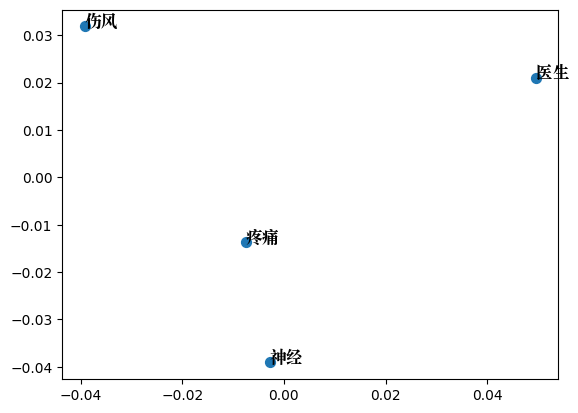

In [29]:
# 可视化词向量
words = ['医生', '疼痛', '神经', '伤风']
vectors = [model.wv[word] for word in words]
from sklearn.decomposition import PCA  # 语义空间降维，用于展示词语在二维空间的相对位置
from matplotlib import font_manager  # 用于设置中文字体显示
font_path = '/System/Library/Fonts/Supplemental/Songti.ttc' # 指定中文字体路径（根据系统修改）
prop = font_manager.FontProperties(fname = font_path)  # 创建字体属性对象
# 使用PCA降维
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(vectors)  
import matplotlib.pyplot as plt  # 画图
# 取PCA降维结果中所有行的第一列和第二列数据绘制散点图，设置点的大小为50
plt.scatter(pca_result[:, 0], pca_result[:, 1], s = 50)

for i, word in enumerate(words):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]), fontproperties = prop, fontsize = 12)

plt.show()

Word2Vec损失分析

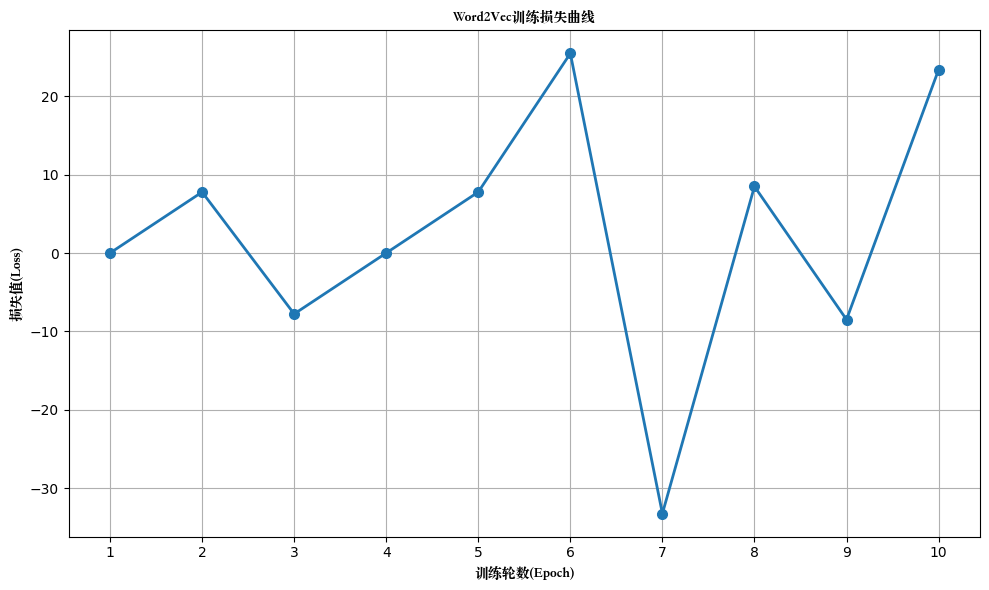


最终模型信息：
词汇表大小：16


In [30]:
#损失计算
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
#指定字体
font_path = '/System/Library/Fonts/Supplemental/Songti.ttc'
# 初始化模型（注意：不要设置 epochs，这里我们手动控制）
model = Word2Vec(
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,
    compute_loss=True
)  
# 构建词汇表
model.build_vocab(corpus)

# 手动逐轮训练并记录损失
losses = []
previous_loss = 0
epochs = 10

for epoch in range(epochs):
    model.train(
        corpus,
        total_examples=model.corpus_count,
        epochs=1,
        compute_loss=True
    )
    current_loss = model.get_latest_training_loss()
    epoch_loss = current_loss - previous_loss
    losses.append(epoch_loss)
    previous_loss = current_loss
## 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, 'o-',  color='#1f77b4',  # 主色：蓝色
    linewidth=2,          # 线条宽度
    markersize=7,         # 标记点大小
    label='Training Loss' # 添加图例标签
)
from matplotlib.font_manager import FontProperties  # Import FontProperties for custom fonts
font_prop = FontProperties(fname=font_path)  # Create a FontProperties object with the specified font path

plt.title('Word2Vec训练损失曲线', fontproperties=font_prop)
plt.xlabel('训练轮数(Epoch)', fontproperties=font_prop)
plt.ylabel('损失值(Loss)', fontproperties=font_prop)
plt.grid(True)
plt.xticks(range(1, epochs + 1))
plt.tight_layout()

plt.show()

## 打印最终模型的一些信息
print("\n最终模型信息：")
print(f"词汇表大小：{len(model.wv.key_to_index)}")